In [ ]:
"""
Baseline for CIL project on road segmentation.
This simple baseline consits of a CNN with two convolutional+pooling layers with a soft-max loss
"""

import gzip
import os
import sys
import urllib
import matplotlib.image as mpimg
from PIL import Image
from random import shuffle
import time

import code

import tensorflow.python.platform

import numpy as np
import tensorflow as tf

import cil_helper as cil

from skimage.feature import greycomatrix, greycoprops

In [ ]:
try:
    tf.app.flags.DEFINE_string('log_dir', '/tmp/tensorflow_lukas_balz',
                           """Directory where to write event logs """
                           """and checkpoint.""")
except: 
    print(tf.app.flags.FLAGS.log_dir)
    
FLAGS = tf.app.flags.FLAGS

In [ ]:
################################################################
######## ONLY CHANGE WHAT YOU ARE TESTING ######################
################################################################
TRAINING_SIZE = 40
VALIDATION_SIZE = 10  # Size of the validation set.
TEST_SIZE = 50
SEED = 66478  # Set to None for random seed.
BATCH_SIZE = 64 # 64
NUM_EPOCHS = 10
RESTORE_MODEL = False # If True, restore existing model instead of training a new one
RECORDING_STEP = 200
ERROR_STEP = 500

# Set image patch size in pixels
# IMG_PATCH_SIZE should be a multiple of 4
# image size should be an integer multiple of this number!
IMG_PATCH_SIZE = 2
NUM_CHANNELS = 3

# all prediction size
ALL_PER = 500

In [ ]:
data_dir = 'training/'
train_data_filename = data_dir + 'images/'
train_labels_filename = data_dir + 'groundtruth/' 
test_dir = "test/"

In [ ]:
# returns all train images in rgb
def get_train_imgs():
    imgs = []
    for i in range(TRAINING_SIZE):
        imageid = "satImage_%.3d" % (i+1)
        image_filename = train_data_filename + imageid + ".png"
        if os.path.isfile(image_filename):
            #print ('Loading ' + image_filename)
            img = mpimg.imread(image_filename)
            imgs.append(img)
        else:
            raise Exception('File ' + image_filename + ' does not exist')
    return np.asarray(imgs)

In [ ]:
def img_crop(im, w, h, pred=False):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [ ]:
# Extract label images
def extract_labels(filename, num_images):
    """Extract the labels into a 1-hot matrix [image index, label index]."""
    gt_imgs = []
    for i in range(1, num_images+1):
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            #print ('Loading ' + image_filename)
            img = mpimg.imread(image_filename)
            gt_imgs.append(img)
        else:
            print ('File ' + image_filename + ' does not exist')

    num_images = len(gt_imgs)
    gt_patches = [img_crop(gt_imgs[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(num_images)]
    data = np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
    labels = np.asarray([value_to_class(np.mean(data[i])) for i in range(len(data))])

    # Convert to dense 1-hot representation.
    return labels.astype(np.float32)

In [ ]:
def make_patches(imgs, num_images):
    #num_images = len(imgs)
    IMG_WIDTH = imgs[0].shape[0]
    IMG_HEIGHT = imgs[0].shape[1]
    DIMS = 4
    N_PATCHES_PER_IMAGE = (IMG_WIDTH/IMG_PATCH_SIZE)*(IMG_HEIGHT/IMG_PATCH_SIZE)

    img_patches = [img_crop(imgs[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(num_images)]
    data = [img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))]

    return np.asarray(data)

In [ ]:
# Assign a label to a patch v
def value_to_class(v):
    foreground_threshold = 0.75 # percentage of pixels > 1 required to assign a foreground label to a patch
    #ret#urn [1-v , v]
    df = np.sum(v)
    if df < foreground_threshold:
       return [0, 1]
    else:
       return [1, 0]

In [ ]:
def load_preproc(save_dir):
    assert save_dir.endswith('/')
    return np.load(save_dir + 'preprocessed2.npy')

In [ ]:
train_preproc = load_preproc(train_data_filename)
train_data = make_patches(train_preproc, TRAINING_SIZE)

train_labels = extract_labels(train_labels_filename, TRAINING_SIZE)

In [ ]:
print(train_data.shape)
train_data = train_data[:,:,:,0:NUM_CHANNELS]
print(train_data.shape)

In [ ]:
c0 = 0
c1 = 0
for i in range(len(train_labels)):
    if train_labels[i][0] > 0.5:
        c0 = c0 + 1 # foreground -> road
    else:
        c1 = c1 + 1 # background
print ('Number of data points per class: c0 = ' + str(c0) + ' c1 = ' + str(c1))

In [ ]:
sampling = False

In [ ]:
print ('Balancing training data...')
min_c = min(c0, c1)
idx0 = [i for i, j in enumerate(train_labels) if j[0] == 1]
idx1 = [i for i, j in enumerate(train_labels) if j[1] == 1]
lim = min_c
    
new_indices = idx0[0:lim] + idx1[0:lim]
train_data = train_data[new_indices,:,:,:]
train_labels = train_labels[new_indices]
    
print(len(new_indices))
print(train_data.shape)

In [ ]:
train_size = train_labels.shape[0]

In [ ]:
# This is where training samples and labels are fed to the graph.
# These placeholder nodes will be fed a batch of training data at each
# training step using the {feed_dict} argument to the Run() call below.
train_data_node = tf.placeholder(
    tf.float32,
    shape=(BATCH_SIZE, IMG_PATCH_SIZE, IMG_PATCH_SIZE, NUM_CHANNELS),
    name='train_data')
train_labels_node = tf.placeholder(
    tf.float32,
    shape=(BATCH_SIZE, cil.NUM_LABELS),
    name='train_labels')
train_all_data_node = tf.constant(train_data)

In [ ]:
# The variables below hold all the trainable weights. They are passed an
# initial value which will be assigned when when we call:
# {tf.initialize_all_variables().run()}
conv3_weights = cil.weight_variable([2, 2, NUM_CHANNELS, 400])
conv3_biases = cil.bias_variable([400])

fc1_weights = tf.Variable(  # fully connected, depth 512.
    tf.truncated_normal([400, 1200],
                        stddev=0.05,
                        seed=SEED))
fc1_biases = tf.Variable(tf.constant(0.05, shape=[1200]))
fc2_weights = tf.Variable(
    tf.truncated_normal([1200, cil.NUM_LABELS],
                        stddev=0.1,
                        seed=SEED))
fc2_biases = tf.Variable(tf.constant(0.1, shape=[cil.NUM_LABELS]))

In [ ]:
# We will replicate the model structure for the training subgraph, as well
# as the evaluation subgraphs, while sharing the trainable parameters.
def model(data, train=False):
    """The Model definition."""
   
    conv3 = cil.conv2d(data, conv3_weights)
    relu3 = tf.nn.relu(tf.nn.bias_add(conv3, conv3_biases))
    pool3 = cil.max_pool_2x2(relu3)

    # Reshape the feature map cuboid into a 2D matrix to feed it to the
    # fully connected layers.
    pool_shape = pool3.get_shape().as_list()
    reshape = tf.reshape(
        pool3,
        [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
    # Fully connected layer. Note that the '+' operation automatically
    # broadcasts the biases.
    
    #print(pool4.get_shape())
    #print(reshape.get_shape())
    #print(fc1_weights.get_shape())
    
    fc1 = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)
    if train:
        fc1 = tf.nn.dropout(fc1, 0.6, seed=SEED)
    fc2 = tf.matmul(fc1, fc2_weights) + fc2_biases

    return fc2

In [ ]:
# Training computation: logits + cross-entropy loss.
logits = model(train_data_node, True) # BATCH_SIZE*NUM_LABELS
# print 'logits = ' + str(logits.get_shape()) + ' train_labels_node = ' + str(train_labels_node.get_shape())
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits, train_labels_node))

In [ ]:
# L2 regularization for the fully connected parameters.
regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
                tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
# Add the regularization term to the loss.
loss += 5e-4 * regularizers

In [ ]:
# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
batch = tf.Variable(0)
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
    0.01,                # Base learning rate.
    batch * BATCH_SIZE,  # Current index into the dataset.
    train_size,          # Decay step.
    0.95,                # Decay rate.
    staircase=True)

In [ ]:
# Use simple momentum for the optimization.
#optimizer = tf.train.MomentumOptimizer(learning_rate, 0.1).minimize(loss, global_step=batch)

# try adam
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=batch)

In [ ]:
# Predictions for the minibatch, validation set and test set.
train_prediction = tf.nn.softmax(logits)
# We'll compute them only once in a while by calling their {eval()} method.
train_all_prediction = tf.nn.softmax(model(train_all_data_node[0:ALL_PER,:,:,:]))

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

In [ ]:
s = tf.InteractiveSession()

In [ ]:
# Get prediction overlaid on the original image for given input image
def get_prediction_with_overlay(img):
    
    img_prediction = get_prediction(img)
    oimg = cil.make_img_overlay(img[:,:,:3], img_prediction)

    return oimg

# Get a concatenation of the prediction and groundtruth for given input file
def get_prediction_with_groundtruth(img):
    
    img_prediction = get_prediction(img)
    cimg = cil.concatenate_images(img[:,:,:3], img_prediction)

    return cimg

# Get prediction for given input image 
def get_prediction(img):
    data = np.asarray(img_crop(img, IMG_PATCH_SIZE, IMG_PATCH_SIZE, True))
    data = data[:,:,:,0:NUM_CHANNELS]
    data_node = tf.constant(data)
    output = tf.nn.softmax(model(data_node))
    output_prediction = s.run(output)
    img_prediction = cil.label_to_img(img.shape[0], img.shape[1], IMG_PATCH_SIZE, IMG_PATCH_SIZE, output_prediction)

    return img_prediction

In [ ]:
# Run all the initializers to prepare the trainable parameters.
tf.initialize_all_variables().run()

print ('Initialized!')

In [ ]:
# Loop through training steps.
print ('Total number of iterations = ' + str(int(NUM_EPOCHS * train_size / BATCH_SIZE)))

training_indices = range(train_size)

for iepoch in range(NUM_EPOCHS):

    # Permute training indices
    perm_indices = np.random.permutation(training_indices)

    for step in range (int(train_size / BATCH_SIZE)):

        offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
        batch_indices = perm_indices[offset:(offset + BATCH_SIZE)]

        # Compute the offset of the current minibatch in the data.
        # Note that we could use better randomization across epochs.
        batch_data = train_data[batch_indices, :, :, :]
        batch_labels = train_labels[batch_indices]
        
        #print('batch_data.shape = ' + str(batch_data.shape))
        # This dictionary maps the batch data (as a numpy array) to the
        # node in the graph is should be fed to.
        feed_dict = {train_data_node: batch_data, train_labels_node: batch_labels}

        stepNr = step + iepoch*int(train_size / BATCH_SIZE)

        if stepNr % ERROR_STEP == 0:
            start_time = time.time()
            l, lr, all_predictions = s.run(
                        [loss, learning_rate, train_all_prediction],
                        feed_dict=feed_dict)
            
            duration = time.time() - start_time
            loss_value = cil.error_rate(all_predictions, train_labels[:ALL_PER,:])
            
            format_str = ('step %d, error: %.1f%% (%.3f sec/batch)')
            print (format_str % (stepNr, loss_value, duration)) 
        elif stepNr % RECORDING_STEP == 0:
            
            start_time = time.time()
            l, lr, all_predictions = s.run(
                        [loss, learning_rate, train_prediction],
                        feed_dict=feed_dict)
            
            duration = time.time() - start_time
            loss_value = cil.error_rate(predictions, batch_labels)
            
            format_str = ('step %d, batch error: %.1f%% (%.3f sec/batch)')
            print (format_str % (stepNr, loss_value, duration)) 
        else:
            # Run the graph and fetch some of the nodes.
            _, l, lr, predictions = s.run(
                        [optimizer, loss, learning_rate, train_prediction],
                        feed_dict=feed_dict)

In [ ]:
save_path = saver.save(s, FLAGS.train_dir + "/model-post-2.ckpt")

In [39]:
saver.restore(s,FLAGS.train_dir + "/model-post-2.ckpt")

In [40]:
run_name = '_eval_postproc2'

In [41]:
print ("Running prediction on training set")
prediction_training_dir = "predictions_training/"
if not os.path.isdir(prediction_training_dir):
    os.mkdir(prediction_training_dir)
    
for i in range(TRAINING_SIZE):
    pimg = get_prediction_with_groundtruth(train_preproc[i])
    Image.fromarray(pimg).save(prediction_training_dir + "prediction_" + run_name + "_" + str(i+1) + ".png")
    oimg = get_prediction_with_overlay(train_preproc[i])
    oimg.save(prediction_training_dir + "overlay_" + run_name + "_" + str(i+1) + ".png")  

Running prediction on training set


In [42]:
print ("Running prediction on validation set")
prediction_test_dir = "predictions_training/"
if not os.path.isdir(prediction_test_dir):
    os.mkdir(prediction_test_dir)

test_preproc = load_preproc(test_dir)
train_labels = extract_labels(train_labels_filename, TRAINING_SIZE+VALIDATION_SIZE)
err = []
for i in range(TRAINING_SIZE, TRAINING_SIZE+VALIDATION_SIZE):
    pimg = get_prediction_with_groundtruth(train_preproc[i])
    Image.fromarray(pimg).save(prediction_training_dir + "prediction_" + run_name + "_" + str(i+1) + ".png")
    oimg = get_prediction_with_overlay(train_preproc[i])
    oimg.save(prediction_training_dir + "overlay_" + run_name + "_" + str(i+1) + ".png")
    img = train_preproc[i]
    data = np.asarray(img_crop(img, IMG_PATCH_SIZE, IMG_PATCH_SIZE, True))
    data = data[:,:,:,0:NUM_CHANNELS]
    data_node = tf.constant(data)
    output = tf.nn.softmax(model(data_node))
    output_prediction = s.run(output)
    error = cil.error_rate(output_prediction, train_labels[data.shape[0]*i:data.shape[0]*(i+1)])
    print(error)
    err.append(error)
print("Mean: " + str(np.mean(err)))

Running prediction on validation set
26.325
28.34
29.7025
28.52
29.1825
23.5025
23.9175
19.1525
29.065
23.54
Mean: 26.12475


In [43]:
output_prediction.shape

(40000, 2)

In [44]:
train_labels[data.shape[0]*i:data.shape[0]*(i+1)].shape

(40000, 2)

In [45]:
data.shape

(40000, 2, 2, 3)

In [49]:
img_prediction = cil.label_to_img(img.shape[0], img.shape[1], IMG_PATCH_SIZE, IMG_PATCH_SIZE, output_prediction)

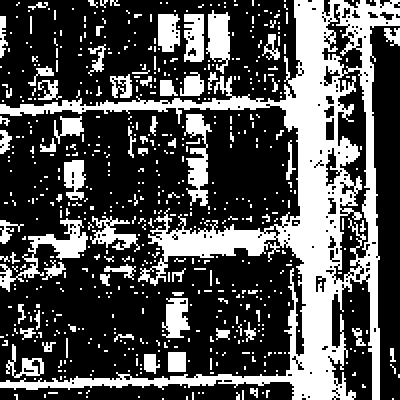

In [50]:
show(img_prediction)

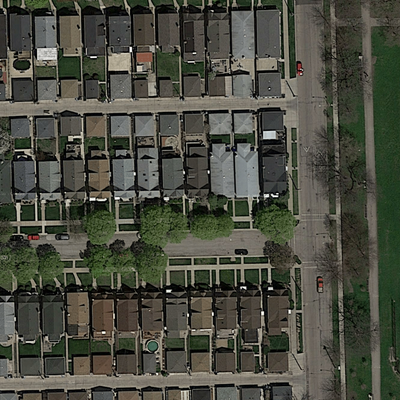

In [59]:
show(train_preproc[i,:,:,:3])

In [48]:
def show(chan):
    chan = chan + chan.min()
    chan = chan / chan.max()
    img = (chan * 255).astype('uint8')
    png = Image.fromarray(img)
    png.show
    return png